In [1]:
%matplotlib inline
import torch
from torch import nn
import lib

$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = lib.synthetic_regression_data(true_w, true_b, n_train)
train_iter = lib.load_array(train_data, batch_size)
test_data = lib.synthetic_regression_data(true_w, true_b, n_test)
test_iter = lib.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [11]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """square loss"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = lib.Accumulator(2)  # sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [12]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = lib.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # add l2 penalty
            # use broadcast to match the shape of `w`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            lib.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w：', torch.norm(w).item())

l2 norm of w： 13.643102645874023


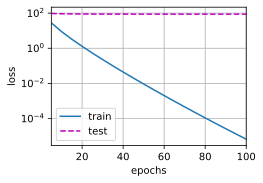

In [13]:
# without regularization
train(lambd=0)

l2 norm of w： 0.36012503504753113


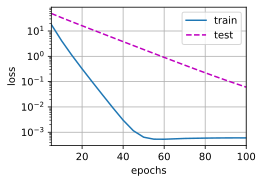

In [14]:
train(lambd=3)

##### Concise version

In [15]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # no need to implement weight decay for b
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = lib.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (evaluate_loss(net, train_iter, loss),
                          evaluate_loss(net, test_iter, loss)))
    print('l2 norm of w：', net[0].weight.norm().item())

l2 norm of w： 13.53770637512207


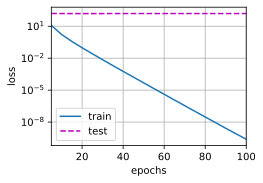

In [16]:
train_concise(0)

l2 norm of w： 0.34431150555610657


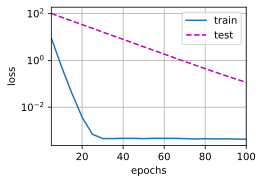

In [17]:
train_concise(3)